In [24]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pickle


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [25]:
testing = pd.read_csv('testingdata2.csv')
training = pd.read_csv('trainingdata2.csv')
index_names = ['unit', 'cycle']
setting_names = ['temp','rh','pressure','ws','wd','ch','solrad']

In [26]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit")
    max_cycle = grouped_by_unit["cycle"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycle"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
training = add_remaining_useful_life(training)
#training[index_names+['RUL']].head()

# This for converting dataframe to CSV
#training.to_csv('RULdata.csv')

In [27]:
settings_df = training[setting_names].copy()
# settings_df['setting_1'] = settings_df['setting_1'].round()
# settings_df['setting_2'] = settings_df['setting_2'].round(decimals=2)
settings_df.groupby(by=setting_names).size()

temp   rh     pressure  ws    wd      ch   solrad
5.67   19.00  146.95    0.35  66.04   0.0  98.11     1
8.06   21.68  190.53    0.71  98.11   0.0  109.48    1
14.16  38.08  334.56    1.24  172.27  0.0  192.24    1
18.44  87.24  610.18    0.07  105.98  0.0  15.49     1
19.87  81.40  601.17    0.33  187.61  0.0  110.67    1
                                                    ..
30.12  63.52  1002.87   1.25  78.28   0.0  154.31    1
30.30  66.90  1008.52   1.02  87.71   0.0  141.39    1
30.32  67.62  1009.96   1.20  84.50   0.0  160.02    1
30.51  63.56  1003.05   1.35  73.82   0.0  190.17    1
33.32  55.06  1003.03   1.79  63.86   0.0  511.85    1
Length: 91, dtype: int64

<ipython-input-34-f8db971eed03>:5: RuntimeWarning: Second argument 'ws' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot('RUL', signal_name,


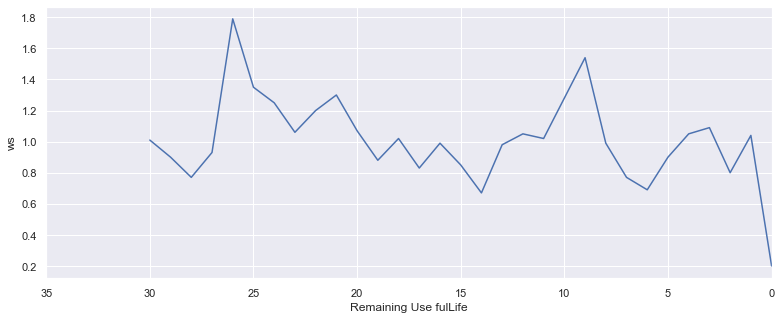

<ipython-input-34-f8db971eed03>:5: RuntimeWarning: Second argument 'rh' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot('RUL', signal_name,


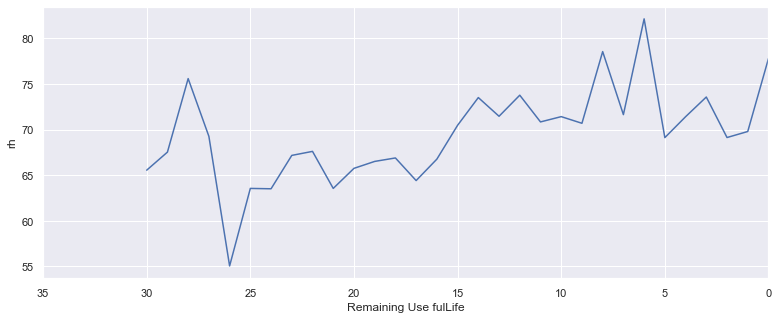

In [34]:
def plot_signal(df, signal_name, unit=None):
    plt.figure(figsize=(13,5))
    
    if unit:
        plt.plot('RUL', signal_name, 
                data=df[df['unit']==unit])
    else:
        for i in training['unit'].unique():
            if (i % 3 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name, 
                         data=df[df['unit']==i])
    plt.xlim(35, 0)  # reverse the x-axis so RUL counts down to zero
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

# specifically plotting setting name, I'm using this as an example throughout the rest of the analysis  
plot_signal(training, 'ws', unit=3)
# specifically plotting setting name, I'm using this as an example throughout the rest of the analysis  
plot_signal(training, 'rh', unit=3)

In [35]:
X_train = training[setting_names].copy()
y_train = training['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

# get last row of each engine
X_test = testing.drop('cycle', axis=1).groupby('unit').last().copy() 

In [36]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [39]:
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:7.326030233849738, R2:0.3002924732227059


ValueError: Found input variables with inconsistent numbers of samples: [30, 1]